# このファイルについて

衛星の熱設計における熱平衡方程式を解きます。
\begin{align*}
 m_ic_i\frac{dT_i}{dt}  = &\sum c_{ij}(T_i-T_j) + \sum \sigma R_{ij} (T_j^4 - T_i^4)\\
 & + (太陽輻射・アルベド)_i+ (地球からの赤外輻射)_i + (内部機器の発熱)_i
\end{align*}

アルベド項と赤外輻射項が時間変動するので厳しい。。。

頑張って

# Requirement

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import math

# 関数など

In [2]:
class Thermal_simu():
    """熱平衡方程式をとくクラス。"""
    def __init__(self,capacity_i,C_ij,R_ij,r_satellite):
        """
        初期化
        Parameters:
        capacity_i: ndarray 1-D vector
            節点iでの熱容量
        C_ij: ndarray 2-D vector
            節点i,jの伝熱によるカップリング
        R_ij: ndarray 2-D vector
            節点i,jの輻射によるカップリング
        r_satellite: ndarray 2-D vector
            衛星の軌道半径。太陽輻射とか計算するときに使う。と思う。
        """
        c_i = self.capacity_i
        C_ij = self.C_ij
        R_ij = self.R_ij
        r = r_satellite
        
        P_s = 1358 # 太陽定数
        
        T_i = np.zeros(i) # 最終的に、熱平衡方程式を解いた結果をここに格納したい
    
    def solve_eq(self):
        """
        全部解いてくれる関数だよ。
        """
        return 0
        
    def sun_radiation(self):
        """
        太陽輻射 

        Parameters:

        Returns:
        q: ndarray
            i番目の成分が節点iにおける太陽輻射による熱入力に対応
        """
        q = 0
        return q
    
    def earth_radiation(self):
        """
        地球の赤外輻射

        Parameters:

        Returns:
        q: ndarray
            i番目の成分が節点iにおける地球の赤外輻射による熱入力に対応
        """
        q = 0
        return q
    
    def albedo(self):
        """
        地球のアルベド

        Parameters:

        Returns:
        q: ndarray
            i番目の成分が節点iにおける地球のアルベドによる熱入力に対応
        """
        q = 0
        return q

In [3]:
class Easy_Thermal_simu():
    """熱平衡方程式をとくクラス。"""
    def __init__(self,A_i,alpha_i,eps_i):
        self.A = A_i
        self.alpha = alpha_i
        self.eps = eps_i
        self.P_s = 1358 # 太陽定数
        self.P_e = 237
        self.T = 0 # 最終的に、熱平衡方程式を解いた結果をここに格納したい
        self.Q_inner = 0
        self.sigma = 5.67*10**(-8)
    
    def solve_eq(self):
        """
        全部解いてくれる関数だよ。
        """
        Q_out_by_T4 = 0
        for i in range(len(self.A)):
            Q_out_by_T4 += self.A[i] * self.eps[i] * self.sigma
        Q_in = self.get_sun_radiation() + self.get_earth_radiation() + self.get_albedo() + self.Q_inner
        self.T = (Q_in/Q_out_by_T4)**0.25
        
    def get_sun_radiation(self):
        """
        太陽輻射 

        Parameters:

        Returns:
        q: ndarray
            i番目の成分が節点iにおける太陽輻射による熱入力に対応
        """
        q = self.P_s * self.A[0] * self.alpha[0] * 1
        return q
    
    def get_earth_radiation(self):
        """
        地球の赤外輻射

        Parameters:

        Returns:
        q: ndarray
            i番目の成分が節点iにおける地球の赤外輻射による熱入力に対応
        """
        q = self.P_e * self.A[5] * self.eps[5] * 1 
        return q
    
    def get_albedo(self):
        """
        地球のアルベド

        Parameters:

        Returns:
        q: ndarray
            i番目の成分が節点iにおける地球のアルベドによる熱入力に対応
        """
        q = self.P_s * 0.3 * self.A[5] * self.alpha[5] * 1
        return q
    
    def set_Q_inner(self,q):
        self.Q_inner = q

In [4]:
alpha = [0.2,0.2,0.2,0.2,0.2,0.2]
eps = [0.8,0.8,0.8,0.8,0.8,0.8]
A = [1,1,1,1,1,1]

sim = Easy_Thermal_simu(A,alpha,eps)
sim.set_Q_inner(500)
sim.solve_eq()
sim.T

248.7892934630962

\begin{align*}
 m_ic_i\frac{dT_i}{dt}  = &\sum c_{ij}(T_i-T_j) + \sum \sigma R_{ij} (T_j^4 - T_i^4)\\
 & + (太陽輻射・アルベド)_i+ (地球からの赤外輻射)_i + (内部機器の発熱)_i
\end{align*}

In [5]:
n_nodes = 2 # 節点数
n_steps = 100
dt = 1

sigma = 1

t = np.arange(0,dt*n_steps,n_steps)              # 時間
m = np.ones(n_nodes)              # 質量
C = np.ones(n_nodes)              # 熱容量
c = np.ones([n_nodes,n_nodes])    # c[i,j]
R = np.ones([n_nodes,n_nodes])    # R[i,j]
T_all = np.ones([n_nodes,n_steps])    # 温度（横に時間軸）

In [67]:
class Thermal_eq:
    sigma = 5.670367e-8 #  Stefan–Boltzmann Constant

    def __init__(self,n_nodes,n_steps,dt):
        self.n_nodes = n_nodes
        self.n_steps = n_steps
        self.dt = dt
        
        self.t = np.arange(0,dt*n_steps,n_steps)              # 時間
        
        self.m = [1. for i in range(n_nodes)]                  # 質量
        self.C = [1. for i in range(n_nodes)]                  # 熱容量
        self.c = [[1. for i in range(n_nodes)] for j in range(n_nodes)]        # c[i,j]
        self.R = [[1. for i in range(n_nodes)] for j in range(n_nodes)]        # R[i,j]
        self.T_all = [[1. for i in range(n_nodes)] for j in range(n_steps)]    # 温度（横に時間軸）
        
        self.Q_in = [[0. for i in range(n_nodes)] for j in range(n_steps)]
        
    def set_params(self,param_m=None,param_C=None,param_c=None,param_R=None):
        if not param_m==None:
            assert len(param_m)==self.n_nodes, 'size of parameter m is different'
            self.t = param_m
        if not param_C==None:
            assert len(param_C)==self.n_nodes, 'size of parameter C is different'
            self.t = param_C
        if not param_c==None:
            assert len(param_c)==self.n_nodes, 'size of parameter c is different'
            self.t = param_c
        if not param_R==None:
            assert len(param_R)==self.n_steps, 'size of parameter R is different'
            self.t = param_R
            
    def set_Q_in(self,n_node,Q_t):
        self.Q_in[n_node] = Q_t
    
    def solve_eq(self,T_init):
        self.T_all[0] = T_init
        for i in range(self.n_steps-1):
            T_temp = self.T_all[i]
            k0 = dt * self.get_dTdt(T_temp)
            k1 = dt * self.get_dTdt([T_temp[i] + k0[i]/2 for i in range(self.n_nodes)])
            k2 = dt * self.get_dTdt([T_temp[i] + k1[i]/2 for i in range(self.n_nodes)])
            k3 = dt * self.get_dTdt([T_temp[i] + k2[i] for i in range(self.n_nodes)])
            k = [(k0[i] + 2*k1[i] + 2*k2[i] + k3[i])/6.0 for i in range(self.n_nodes)]
            self.T_all[i+1] = [T_temp[i] + dt*k[i] for i in range(self.n_nodes)]
    
    def get_dTdt(self,T):
        dTdt = [0 for i in range(self.n_nodes)]
        for i in range(self.n_nodes):
            sum_1 = sum([self.c[i][j]*(T[i]-T[j]) for j in range(self.n_nodes)])
            sum_2 = self.sigma * sum([self.R[i][j]*(T[j]**4-T[i]**4) for j in range(self.n_nodes)])
            dTdt[i] = (sum_1 + sum_2) / self.m[i] / self.C[i]
        return dTdt

In [68]:
eq = Thermal_eq(n_nodes=2,n_steps=100,dt=1)

In [69]:
eq.solve_eq([1,2])

熱入力計算

In [82]:
math.pi

3.141592653589793

In [117]:
Ps = 1358
Pe = 237
Pa = Ps*0.3
T_rev = 100

A = [1,1,1,1,1,1]
alpha = [1,1,1,1,1,1]
eps = [1,1,1,1,1,1]

In [76]:
def is_even(num):
    if num % 2 == 0:
        return True
    else:
        return False

In [94]:
def get_Q1(n_steps,dt,A,alpha,eps):
    Q_s = [alpha[0]*A[0]*1*Ps if is_even(i*dt*2//T_rev) else 0 for i in range(n_steps)]
    Q_e = [-eps[0]*A[0]*math.sin(2*math.pi*i*dt/T_rev)*Pe if not is_even(i*dt*2//T_rev) else 0 for i in range(n_steps)]
    Q1 = [Q_s[i] + Q_e[i] for i in range(n_steps)]
    return Q1

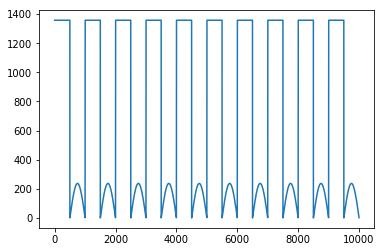

In [99]:
plt.plot(get_Q1(10000,0.01,[1],[1],[1]))

In [126]:
def get_Q2(n_steps,dt,A,alpha,eps):
    Q_a = [-alpha[0]*A[0]*math.cos(2*math.pi*i*dt/T_rev)*Pa if (i*dt*2//(T_rev/2))%4==1 else 0 for i in range(n_steps)]
    Q_e = [-eps[0]*A[0]*math.cos(2*math.pi*i*dt/T_rev)*Pe if (i*dt*2//(T_rev/2))%4==2 else 0 for i in range(n_steps)]
    Q2 = [Q_a[i] + Q_e[i] for i in range(n_steps)]
    return Q2

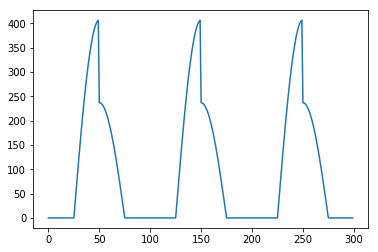

In [127]:
plt.plot(get_Q2(300,1,A,alpha,eps))

In [130]:
def get_Q3(n_steps,dt,A,alpha,eps):
    return [0 for i in range(n_steps)]

In [131]:
def get_Q4(n_steps,dt,A,alpha,eps):
    Q_a = [-alpha[0]*A[0]*math.cos(2*math.pi*i*dt/T_rev)*Pa if (i*dt*2//(T_rev/2))%4==0 else 0 for i in range(n_steps)]
    Q_e = [-eps[0]*A[0]*math.cos(2*math.pi*i*dt/T_rev)*Pe if (i*dt*2//(T_rev/2))%4==3 else 0 for i in range(n_steps)]
    Q4 = [Q_a[i] + Q_e[i] for i in range(n_steps)]
    return Q4

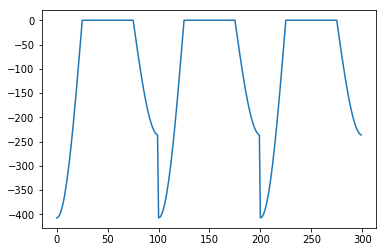

In [132]:
plt.plot(get_Q4(300,1,A,alpha,eps))

In [133]:
def get_Q5(n_steps,dt,A,alpha,eps):
    return [0 for i in range(n_steps)]

In [102]:
def get_Q6(n_steps,dt,A,alpha,eps):
    Q_albedo = [alpha[5]*A[5]*math.sin(2*math.pi*i*dt/T_rev)*Pa if is_even(i*dt*2//T_rev) else 0 for i in range(n_steps)]
    Q_e = [-eps[0]*A[0]*math.sin(2*math.pi*i*dt/T_rev)*Pe if is_even(i*dt*2//T_rev) else 0 for i in range(n_steps)]
    Q6 = [Q_albedo[i] + Q_e[i] for i in range(n_steps)]
    return Q6

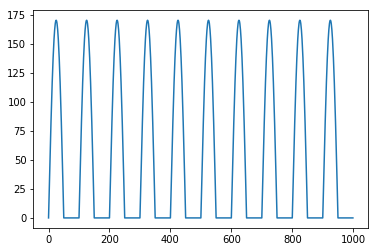

In [104]:
plt.plot(get_Q6(1000,0.1,A,alpha,eps))